# Work with the .mod files

In [2]:
notes = """
Protracker 1.1B Song/Module Format:
-----------------------------------

Offset  Bytes  Description
------  -----  -----------
   0     20    Songname. Remember to put trailing null bytes at the end...

Information for sample 1-31:

Offset  Bytes  Description
------  -----  -----------
  20     22    Samplename for sample 1. Pad with null bytes.
  42      2    Samplelength for sample 1. Stored as number of words.
               Multiply by two to get real sample length in bytes.
  44      1    Lower four bits are the finetune value, stored as a signed
               four bit number. The upper four bits are not used, and
               should be set to zero.
               Value:  Finetune:
                 0        0
                 1       +1
                 2       +2
                 3       +3
                 4       +4
                 5       +5
                 6       +6
                 7       +7
                 8       -8
                 9       -7
                 A       -6
                 B       -5
                 C       -4
                 D       -3
                 E       -2
                 F       -1

  45      1    Volume for sample 1. Range is $00-$40, or 0-64 decimal.
  46      2    Repeat point for sample 1. Stored as number of words offset
               from start of sample. Multiply by two to get offset in bytes.
  48      2    Repeat Length for sample 1. Stored as number of words in
               loop. Multiply by two to get replen in bytes.

Information for the next 30 samples starts here. It's just like the info for
sample 1.

Offset  Bytes  Description
------  -----  -----------
  50     30    Sample 2...
  80     30    Sample 3...
   .
   .
   .
 890     30    Sample 30...
 920     30    Sample 31...

Offset  Bytes  Description
------  -----  -----------
 950      1    Songlength. Range is 1-128.
 951      1    Well... this little byte here is set to 127, so that old
               trackers will search through all patterns when loading.
               Noisetracker uses this byte for restart, but we don't.
 952    128    Song positions 0-127. Each hold a number from 0-63 that
               tells the tracker what pattern to play at that position.
1080      4    The four letters "M.K." - This is something Mahoney & Kaktus
               inserted when they increased the number of samples from
               15 to 31. If it's not there, the module/song uses 15 samples
               or the text has been removed to make the module harder to
               rip. Startrekker puts "FLT4" or "FLT8" there instead.

Offset  Bytes  Description
------  -----  -----------
1084    1024   Data for pattern 00.
   .
   .
   .
xxxx  Number of patterns stored is equal to the highest patternnumber
      in the song position table (at offset 952-1079).

Each note is stored as 4 bytes, and all four notes at each position in
the pattern are stored after each other.

00 -  chan1  chan2  chan3  chan4
01 -  chan1  chan2  chan3  chan4
02 -  chan1  chan2  chan3  chan4
etc.

Info for each note:

 _____byte 1_____   byte2_    _____byte 3_____   byte4_
/                \ /      \  /                \ /      \
0000          0000-00000000  0000          0000-00000000

Upper four    12 bits for    Lower four    Effect command.
bits of sam-  note period.   bits of sam-
ple number.                  ple number.

Periodtable for Tuning 0, Normal
  C-1 to B-1 : 856,808,762,720,678,640,604,570,538,508,480,453
  C-2 to B-2 : 428,404,381,360,339,320,302,285,269,254,240,226
  C-3 to B-3 : 214,202,190,180,170,160,151,143,135,127,120,113

To determine what note to show, scan through the table until you find
the same period as the one stored in byte 1-2. Use the index to look
up in a notenames table.

This is the data stored in a normal song. A packed song starts with the
four letters "PACK", but i don't know how the song is packed: You can
get the source code for the cruncher/decruncher from us if you need it,
but I don't understand it; I've just ripped it from another tracker...

In a module, all the samples are stored right after the patterndata.
To determine where a sample starts and stops, you use the sampleinfo
structures in the beginning of the file (from offset 20). Take a look
at the mt_init routine in the playroutine, and you'll see just how it
is done.

Refs:
https://www.ocf.berkeley.edu/~eek/index.html/tiny_examples/ptmod/ap12.html
https://forums.atariage.com/topic/157184-imagitec-designs-mod-player-informations/
"""

## Unpack a mod file

In [1]:
!ffplay tunes/tune12.mod

ffplay version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2003-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [1]:
import os

def getTuneData(tune_name):
    tune = open(tune_name,"rb")

    song_name = tune.read(20).replace(b'\x00',b'')

    sample_name, length, fine_tune, volume, repeat_point, repeat_len = [],[],[],[],[],[]
    for i in range(0,31):
        sample_name     += [tune.read(22).replace(b'\x00',b'')]
        length          += [int.from_bytes(tune.read(2), "big") * 2]
        fine_tune       += [int.from_bytes(tune.read(1), "big")]
        volume          += [int.from_bytes(tune.read(1), "big")]
        repeat_point    += [int.from_bytes(tune.read(2), "big")]
        repeat_len      += [int.from_bytes(tune.read(2), "big")]
    song_length = int.from_bytes(tune.read(1), "big")
    sentinel = int.from_bytes(tune.read(1), "big")
    song_positions = [x for x in tune.read(128)]
    m_k = tune.read(4)

    num_patterns = max(song_positions)
    patterns = []
    for p in range(0,num_patterns+1):
        chord_bytes = tune.read(1024)
        chords = []
        for n in range(0,1024,16):
            chord = []
            for o in range(n,n+16,4):
                raw_bytes = [x for x in chord_bytes[o:o+4]]
                sample_hi = raw_bytes[0] & 0xF0 >> 4
                note_period = ((raw_bytes[0] & 0x0F) << 8) + raw_bytes[1]
                sample_lo = raw_bytes[2] & 0xF0 >> 4
                effect_command = ((raw_bytes[2] & 0x0F) << 8) + raw_bytes[3]
                chord += [[sample_hi,note_period,sample_lo,effect_command]]
            chords += [chord]
        patterns += [chords]

    samples = []
    for l in length:
        samples += [tune.read(l)]
    return {
        "song_name": song_name,
        "sample_name": sample_name,
        "length": length,
        "fine_tune": fine_tune,
        "volume": volume,
        "repeat_point": repeat_point,
        "repeat_len": repeat_len,
        "song_length": song_length,
        "sentinel": sentinel,
        "song_positions": song_positions,
        "m_k": m_k,
        "patterns": patterns,
        "samples": samples
    }


## Convert the Samples in the Mod File to Wav

In [9]:
TUNE_NAME = "tunes/tune3.mod"
tune_data = getTuneData(TUNE_NAME)
samples = tune_data["samples"]

open("rawsample",'wb').write(samples[1])
!play -t raw -r 8k -e signed-integer -b 8 -c 2 rawsample

play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 8-bit Signed Integer PCM

rawsample:

 File Size: 6.35k     Bit Rate: 128k
  Encoding: Signed PCM    
  Channels: 2 @ 8-bit    
Samplerate: 8000Hz       
Replaygain: off         
  Duration: 00:00:00.40  

In:100%  00:00:00.40 [00:00:00.00] Out:3.18k [!=====|=====!]        Clip:0    
Done.


In [127]:
import numpy as np
from scipy.io.wavfile import write
from scipy import signal as sg
def signed(x): return (((x >> 7) * 128) ^ x) - ((x >> 7) * 128)
import wave
import os

TUNE_DIR = "tunes/"
TUNE_NAME = "tune3.mod"
tune_data = getTuneData(TUNE_DIR+TUNE_NAME)
samples = tune_data["samples"]

SMP_DIR = "samples/"
wav_files = []
for i,bs in enumerate(samples):
    sname = f"{SMP_DIR}{TUNE_NAME}-{i}.wav"
    wav_files += [sname]
    if not bs:
        continue
    data = [signed(bs[i]) for i in range(0,len(bs))]
    scaled = np.int16(data/np.max(np.abs(data)) * 32767) 
    
    with wave.open(sname, "wb") as out_f:
        out_f.setnchannels(2)
        out_f.setsampwidth(2) # number of bytes
        out_f.setframerate(10000)
        out_f.writeframes(scaled)



In [10]:
!play samples/tune3.mod-16.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable

samples/tune3.mod-16.wav:

 File Size: 19.2k     Bit Rate: 321k
  Encoding: Signed PCM    
  Channels: 2 @ 16-bit   
Samplerate: 10000Hz      
Replaygain: off         
  Duration: 00:00:00.48  

In:100%  00:00:00.48 [00:00:00.00] Out:4.80k [!=====|=====!]        Clip:0    
Done.


## Create Spectrograms

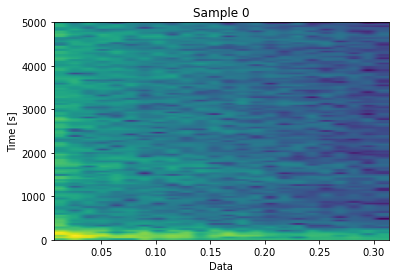

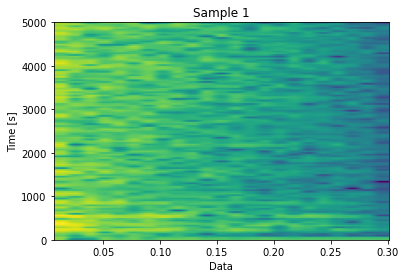

/tmp/ipykernel_268959/3438948421.py:9: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=245).
  powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(aud[:,0], Fs=Fs)


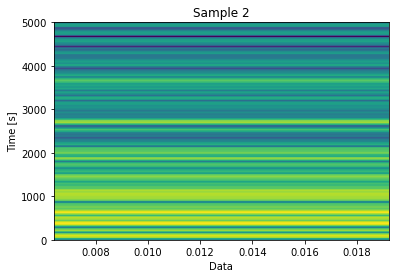

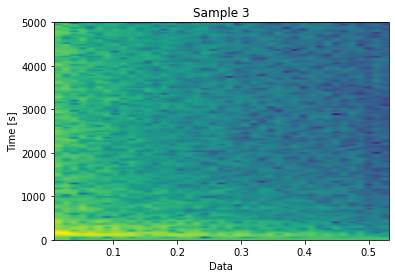

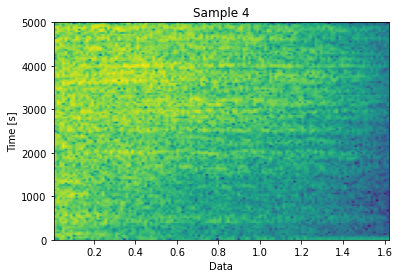

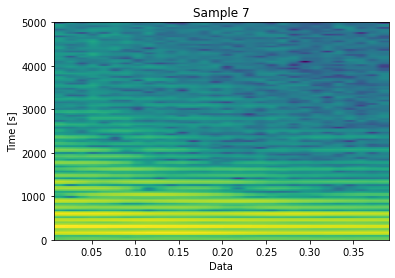

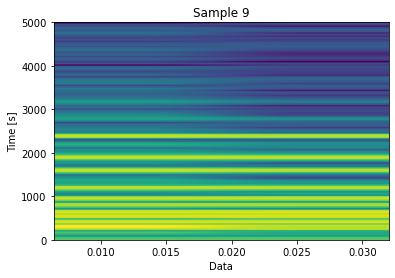

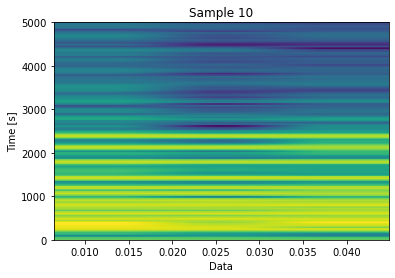

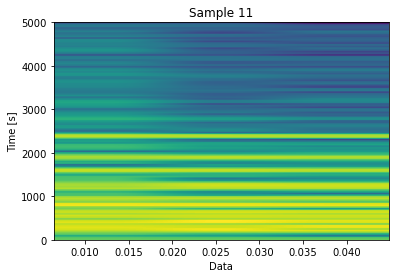

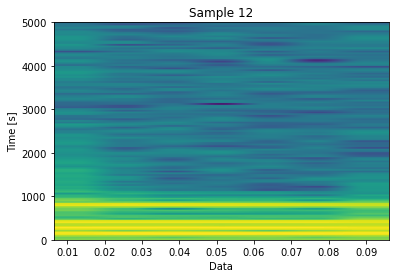

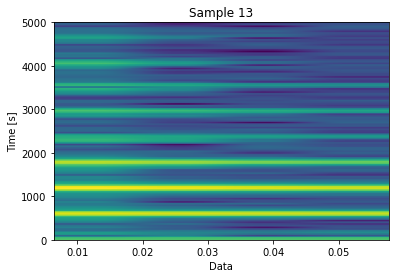

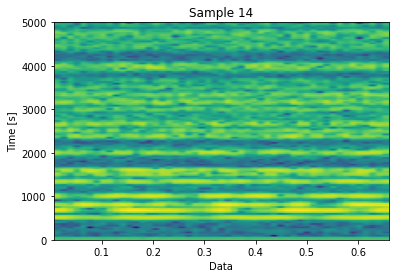

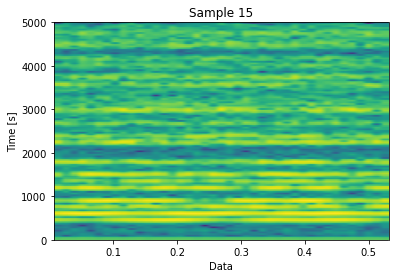

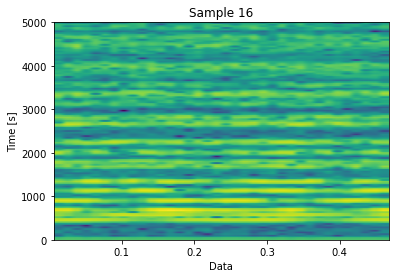

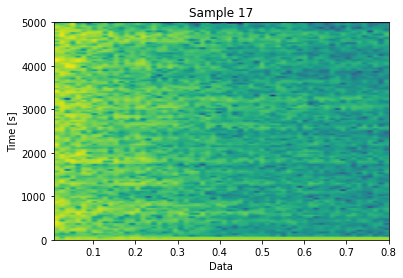

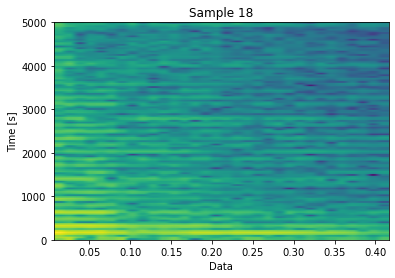

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

for i,wav_file in enumerate(wav_files):
    if not os.path.isfile(wav_file):
        continue
    Fs, aud = wavfile.read(wav_file)
    powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(aud[:,0], Fs=Fs)
    title = f"Sample {i}"
    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel("Time [s]")
    plt.savefig(f"{wav_file}-spec.png", bbox_inches="tight")
    plt.show()
    

## Create Sine Wave Plots

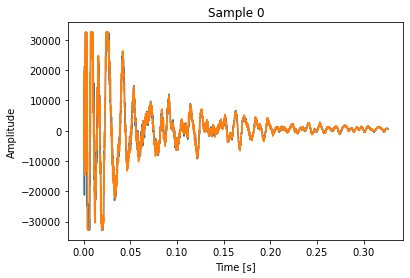

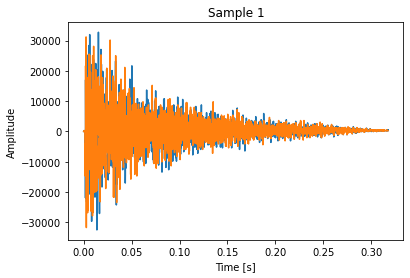

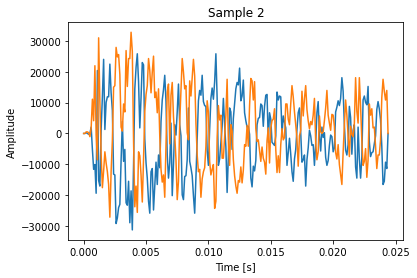

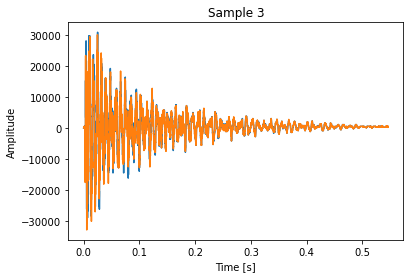

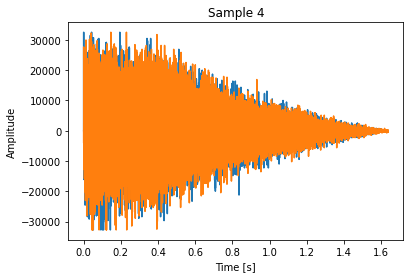

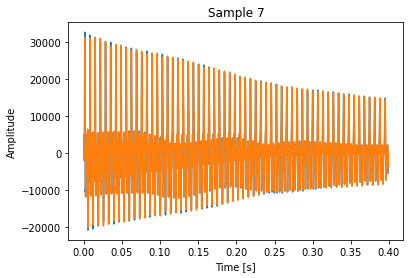

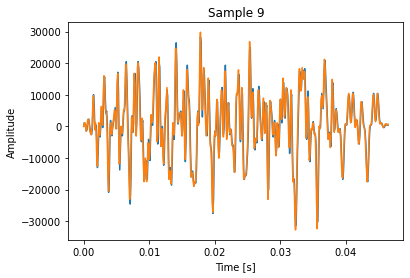

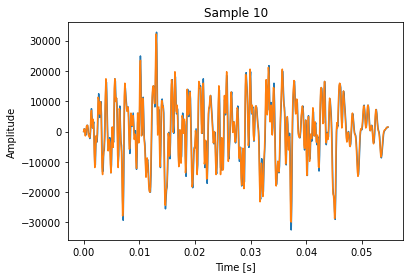

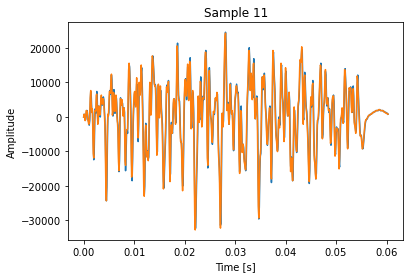

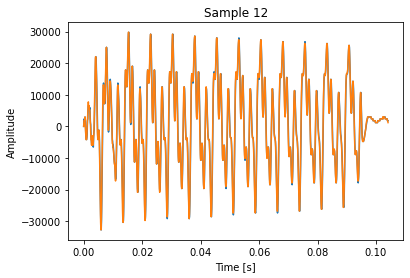

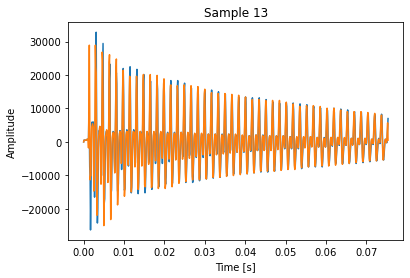

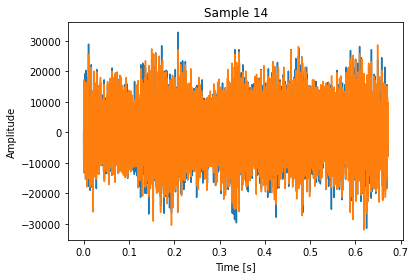

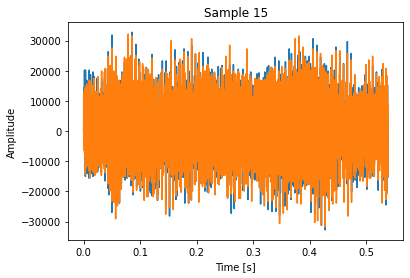

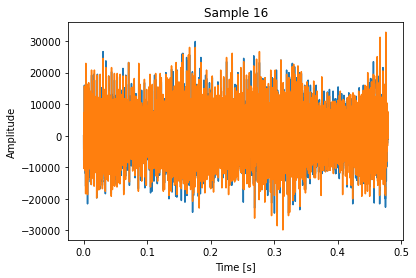

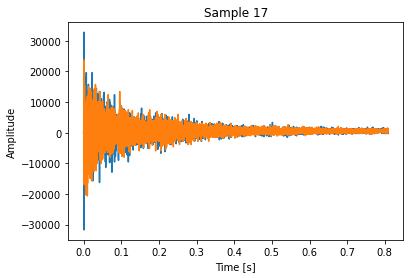

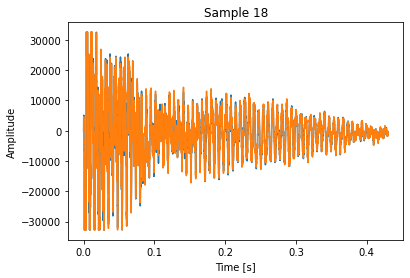

In [130]:
import os
import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt

for i,wavedata in enumerate(wav_files):
    if not os.path.isfile(wavedata):
        continue
    sampleRate, audioBuffer = scipy.io.wavfile.read(wavedata)
    duration = len(audioBuffer)/sampleRate
    time = np.arange(0,duration,1/sampleRate) #time vector

    plt.plot(time,audioBuffer)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    title = f"Sample {i}"
    plt.title(title)
    plt.savefig(f"{wavedata}-amp.png", bbox_inches="tight")
    plt.show()


## Figure out what is in leftover data

paddingbetweentunesandsmp.bin is a leftover part of various tune mods. Some unused in the game.

In [134]:
!play -t raw -r 8k -e signed-integer -b 8 -c 2 \
    ../../tempest2k/src/incbin/paddingbetweentunesandsmp.bin

play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 8-bit Signed Integer PCM

../../tempest2k/src/incbin/tunex.mod:

 File Size: 153k      Bit Rate: 128k
  Encoding: Signed PCM    
  Channels: 2 @ 8-bit    
Samplerate: 8000Hz       
Replaygain: off         
  Duration: 00:00:09.56  

In:100%  00:00:09.56 [00:00:00.00] Out:76.5k [      |      ] Hd:0.0 Clip:0    
Done.


In [326]:
tune_data = {f:open(f"tunes/{f}",'rb').read()
             for f in os.listdir('tunes')
             if f.endswith("mod") or f.endswith("MOD")
            }

In [184]:
def getTuneWithBytes(bs):
    matches = []
    for n in tune_data:
        if bs in tune_data[n]:
            matches += [n]
    return matches

### Look for segments of data that match segments in the tune files

In [253]:
padding_data = open("tunes/paddingbetweentunesandsmp.bin",'rb').read()
STEP=128
prev_tune = ""
first = 0
for o in range(0, len(padding_data), STEP):
    cur_tune = getTuneWithBytes(padding_data[o:o+STEP])
    if prev_tune== "":
        prev_tune = cur_tune
        continue
    if cur_tune == prev_tune:
        continue
    print(f"{first}-{o+STEP}", prev_tune)
    prev_tune = cur_tune
    first = o+STEP

0-3200 ['tune12.mod']
3200-3328 []
3328-10880 ['tune7.mod', 'TUNE11.MOD']
10880-11008 ['tune7.mod']
11008-15616 ['TUNE4.MOD', 'tune7.mod', 'TUNE6.MOD', 'rave4.mod']
15616-15744 ['TUNE4.MOD', 'tune7.mod', 'rave4.mod']
15744-18048 ['TUNE4.MOD', 'tune7.mod', 'TUNE6.MOD', 'rave4.mod']
18048-18176 ['TUNE4.MOD', 'tune7.mod', 'rave4.mod']
18176-20608 ['TUNE4.MOD', 'tune7.mod', 'TUNE6.MOD', 'rave4.mod']
20608-23296 ['TUNE4.MOD', 'tune7.mod', 'rave4.mod']
23296-23424 []
23424-23680 ['TUNE4.MOD', 'tune7.mod', 'TUNE6.MOD', 'rave4.mod']
23680-23808 ['TUNE6.MOD']
23808-26112 ['TUNE4.MOD', 'tune7.mod', 'TUNE6.MOD', 'rave4.mod']
26112-37376 ['TUNE6.MOD']


In [301]:
print(
    padding_data[:3188] in tune_data["tune12.mod"],
    padding_data[3188:3192].hex(),
    padding_data[3192:23172] in tune_data["tune7.mod"],
    padding_data[23172:23176].hex(),
    padding_data[23176:37252] in tune_data["TUNE6.MOD"],
    padding_data[37252:37256].hex(),
    padding_data[37256:] in tune_data["TUNE6.MOD"],
     )

True 00000000 True 00000000 True 00000000 True


# Compare the Unused Data with the Samples Directly

In [327]:
samples_data = {
    f: getTuneData(f"tunes/{f}")
    for f in os.listdir('tunes')
    if f.endswith("mod") or f.endswith("MOD")
}

### Get the samples that appear in more than one tune

In [328]:
import hashlib
import collections
all_samples = {}
for tune,samples in samples_data.items():
    for i,bs in enumerate(samples["samples"]):
        if not bs:
            continue
        h = hashlib.sha256(bs).hexdigest()
        all_samples.setdefault(h,[]).append((tune,i))
[(x,y) for x,y in all_samples.items() if len(y) > 1]


[('53d672beed973b434ff7d49bf5b3336a97b0da307c9a59a4bae604a75f0d1f0b',
  [('tune12.mod', 5), ('TUNE2.MOD', 5)]),
 ('baf4a2200727b5ff864cdde8331e3a22324d08ef45a29c5ce7b7ddc93cd784b7',
  [('tune7.mod', 0), ('rave4.mod', 6)]),
 ('ff0cfc4e2de9798ff67e9d1e783675447be26199107c5f31665de5f5dc74c2e8',
  [('tune7.mod', 1), ('TUNE11.MOD', 1)]),
 ('c09e3a95bf5fa7b5409f19fd0c1acc08b8f24630f071d814e72eb2db2725f21c',
  [('tune7.mod', 11), ('TUNE6.MOD', 5), ('TUNE11.MOD', 11)]),
 ('df9561989df2bf56f2a6d4910fe9842268a11ac3855483420acc32f5496a8c8a',
  [('tune7.mod', 22), ('TUNE11.MOD', 22)]),
 ('73b478d34262aa56bd08259c6bdfcc86717bb2030d988464ee911b9f0be3b964',
  [('tune7.mod', 25), ('TUNE11.MOD', 25)]),
 ('9212815df19b08bd91d639aaea4f4b953b9d19a0192f28f7befc226539153ccd',
  [('tune7.mod', 26), ('TUNE6.MOD', 7), ('rave4.mod', 25)]),
 ('47bea12feb91debed0680e1b6bbf528af670269fdac4b102c173b01e2606d68f',
  [('tune7.mod', 27), ('rave4.mod', 26)]),
 ('27bab6e0592bbbc78c7c6c182d2f5da9c700a211681a6c9e8b0e935622

### Get the samples present in the unused data

In [339]:
samples_present = []
for tune,samples in samples_data.items():
    for i,bs in enumerate(samples["samples"]):
        if not bs:
            continue
        if bs in padding_data:
            samples_present += [(tune, f"sample {i}", padding_data.index(bs), len(bs))]
sorted(samples_present,key=lambda x:x[2])

[('tune7.mod', 'sample 25', 9216, 1618),
 ('TUNE11.MOD', 'sample 25', 9216, 1618),
 ('tune7.mod', 'sample 26', 10834, 2196),
 ('TUNE6.MOD', 'sample 7', 10834, 2196),
 ('rave4.mod', 'sample 25', 10834, 2196),
 ('tune7.mod', 'sample 27', 13030, 2556),
 ('TUNE6.MOD', 'sample 8', 13030, 2548),
 ('rave4.mod', 'sample 26', 13030, 2556),
 ('tune7.mod', 'sample 28', 15586, 2454),
 ('TUNE6.MOD', 'sample 9', 15586, 2438),
 ('rave4.mod', 'sample 27', 15586, 2454),
 ('tune7.mod', 'sample 29', 18040, 2474),
 ('TUNE6.MOD', 'sample 6', 18040, 2464),
 ('rave4.mod', 'sample 28', 18040, 2474),
 ('tune7.mod', 'sample 30', 20514, 2658),
 ('rave4.mod', 'sample 29', 20514, 2658),
 ('TUNE6.MOD', 'sample 10', 26088, 1138),
 ('TUNE6.MOD', 'sample 11', 27226, 10026)]

### Write out all the samples in all the tunes to wav files

In [308]:
import numpy as np
from scipy.io.wavfile import write
from scipy import signal as sg
def signed(x): return (((x >> 7) * 128) ^ x) - ((x >> 7) * 128)
import wave
import os

SMP_DIR = "tune_samples/"
wav_files = []
for tune,samples in samples_data.items():
    for i,bs in enumerate(samples["samples"]):
        sname = f"{SMP_DIR}{tune}-{i}.wav"
        wav_files += [sname]

        if not bs:
            continue
        data = [signed(bs[i]) for i in range(0,len(bs))]
        scaled = np.int16(data/np.max(np.abs(data)) * 32767) 

        with wave.open(sname, "wb") as out_f:
            out_f.setnchannels(2)
            out_f.setsampwidth(2) # number of bytes
            out_f.setframerate(10000)
            out_f.writeframes(scaled)



## Create Sheet Music Maybe?

In [66]:
"""
Periodtable for Tuning 0, Normal
  C-1 to B-1 : 856,808,762,720,678,640,604,570,538,508,480,453
  C-2 to B-2 : 428,404,381,360,339,320,302,285,269,254,240,226
  C-3 to B-3 : 214,202,190,180,170,160,151,143,135,127,120,113
"""

note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
note_table = [
    856,808,762,720,678,640,604,570,538,508,480,453,
    428,404,381,360,339,320,302,285,269,254,240,226,
    214,202,190,180,170,160,151,143,135,127,120,113]
len(note_table)

36

In [84]:
def get1Note(n,o):
    x=856<<6
    for i in range(0,n):
        x = (x*61858) >> 16
    x= x >> (o+4)
    return x

get1Note(3,1)

1439

## Play with spare sample(?) data

In [3]:
!play -t raw -r 8k -e signed-integer -b 8 -c 2 \
    tunes/paddingbetweentunesandsmp.bin

play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 8-bit Signed Integer PCM

tunes/paddingbetweentunesandsmp.bin:

 File Size: 37.3k     Bit Rate: 128k
  Encoding: Signed PCM    
  Channels: 2 @ 8-bit    
Samplerate: 8000Hz       
Replaygain: off         
  Duration: 00:00:02.33  

In:100%  00:00:02.33 [00:00:00.00] Out:18.7k [      |      ] Hd:0.0 Clip:0    
Done.
